In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from tensorflow import keras

In [8]:
data_dir = pathlib.Path('./Dataset/')
image_count = len(list(data_dir.glob('*/*.jpeg')))
print('Hay un total de '+str(image_count)+' imagenes')

epitrix = list(data_dir.glob('epitrix/*'))
sano = list(data_dir.glob('sano/*'))
tizon = list(data_dir.glob('tizon/*'))

batch_size = 256
img_hei=224
img_wid=224

Hay un total de 183 imagenes


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_hei, img_wid),
    batch_size = batch_size
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_hei, img_wid),
    batch_size= batch_size
)

Found 183 files belonging to 3 classes.
Using 147 files for training.
Found 183 files belonging to 3 classes.
Using 36 files for validation.


['epitrix', 'sano', 'tizon']


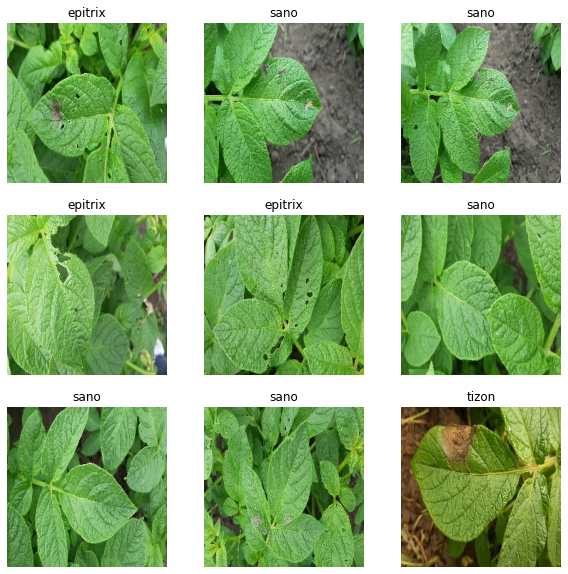

In [10]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch , labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

num_classes = 3

0.0 1.0


In [32]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_hei, img_wid, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(224, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(num_classes)
])



model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

epochs=500
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 56, 56, 64)      

1/1 [==============================] - 2s 2s/step - loss: 1.0914 - accuracy: 0.3741 - val_loss: 1.1171 - val_accuracy: 0.2222
Epoch 36/500
1/1 [==============================] - 2s 2s/step - loss: 1.0902 - accuracy: 0.4218 - val_loss: 1.1210 - val_accuracy: 0.3611
Epoch 37/500
1/1 [==============================] - 2s 2s/step - loss: 1.0902 - accuracy: 0.3946 - val_loss: 1.1187 - val_accuracy: 0.3611
Epoch 38/500
1/1 [==============================] - 2s 2s/step - loss: 1.0870 - accuracy: 0.3673 - val_loss: 1.1132 - val_accuracy: 0.3056
Epoch 39/500
1/1 [==============================] - 2s 2s/step - loss: 1.0860 - accuracy: 0.3741 - val_loss: 1.1105 - val_accuracy: 0.3333
Epoch 40/500
1/1 [==============================] - 2s 2s/step - loss: 1.0839 - accuracy: 0.4014 - val_loss: 1.1166 - val_accuracy: 0.3611
Epoch 41/500
1/1 [==============================] - 2s 2s/step - loss: 1.0833 - accuracy: 0.3605 - val_loss: 1.1065 - val_accuracy: 0.3333
Epoch 42/500
1/1 [======================

1/1 [==============================] - 2s 2s/step - loss: 0.9330 - accuracy: 0.5714 - val_loss: 0.9727 - val_accuracy: 0.7222
Epoch 95/500
1/1 [==============================] - 2s 2s/step - loss: 0.9684 - accuracy: 0.5306 - val_loss: 0.9561 - val_accuracy: 0.7500
Epoch 96/500
1/1 [==============================] - 2s 2s/step - loss: 0.9670 - accuracy: 0.5034 - val_loss: 0.9425 - val_accuracy: 0.8333
Epoch 97/500
1/1 [==============================] - 2s 2s/step - loss: 0.9353 - accuracy: 0.5782 - val_loss: 0.9657 - val_accuracy: 0.7222
Epoch 98/500
1/1 [==============================] - 2s 2s/step - loss: 0.9538 - accuracy: 0.5102 - val_loss: 0.9555 - val_accuracy: 0.7500
Epoch 99/500
1/1 [==============================] - 2s 2s/step - loss: 0.9383 - accuracy: 0.5510 - val_loss: 0.9808 - val_accuracy: 0.7222
Epoch 100/500
1/1 [==============================] - 2s 2s/step - loss: 0.9740 - accuracy: 0.5306 - val_loss: 0.9730 - val_accuracy: 0.7778
Epoch 101/500
1/1 [====================

1/1 [==============================] - 2s 2s/step - loss: 0.8350 - accuracy: 0.6871 - val_loss: 0.9393 - val_accuracy: 0.7222
Epoch 153/500
1/1 [==============================] - 2s 2s/step - loss: 0.8665 - accuracy: 0.5986 - val_loss: 0.8823 - val_accuracy: 0.8611
Epoch 154/500
1/1 [==============================] - 2s 2s/step - loss: 0.8138 - accuracy: 0.6531 - val_loss: 0.9198 - val_accuracy: 0.7222
Epoch 155/500
1/1 [==============================] - 2s 2s/step - loss: 0.9085 - accuracy: 0.5918 - val_loss: 0.8948 - val_accuracy: 0.8056
Epoch 156/500
1/1 [==============================] - 2s 2s/step - loss: 0.8439 - accuracy: 0.6803 - val_loss: 0.9096 - val_accuracy: 0.7222
Epoch 157/500
1/1 [==============================] - 2s 2s/step - loss: 0.9504 - accuracy: 0.5442 - val_loss: 0.9509 - val_accuracy: 0.6667
Epoch 158/500
1/1 [==============================] - 2s 2s/step - loss: 0.9730 - accuracy: 0.5034 - val_loss: 0.9148 - val_accuracy: 0.7500
Epoch 159/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7619 - accuracy: 0.6735 - val_loss: 0.7988 - val_accuracy: 0.8611
Epoch 211/500
1/1 [==============================] - 2s 2s/step - loss: 0.7713 - accuracy: 0.6531 - val_loss: 0.8146 - val_accuracy: 0.8611
Epoch 212/500
1/1 [==============================] - 2s 2s/step - loss: 0.8076 - accuracy: 0.6190 - val_loss: 0.7901 - val_accuracy: 0.8889
Epoch 213/500
1/1 [==============================] - 2s 2s/step - loss: 0.7871 - accuracy: 0.6531 - val_loss: 0.7921 - val_accuracy: 0.8889
Epoch 214/500
1/1 [==============================] - 2s 2s/step - loss: 0.7446 - accuracy: 0.6803 - val_loss: 0.7886 - val_accuracy: 0.8611
Epoch 215/500
1/1 [==============================] - 2s 2s/step - loss: 0.7857 - accuracy: 0.6463 - val_loss: 0.7836 - val_accuracy: 0.8889
Epoch 216/500
1/1 [==============================] - 2s 2s/step - loss: 0.7811 - accuracy: 0.6463 - val_loss: 0.7737 - val_accuracy: 0.8889
Epoch 217/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7581 - accuracy: 0.6395 - val_loss: 0.7501 - val_accuracy: 0.8611
Epoch 269/500
1/1 [==============================] - 2s 2s/step - loss: 0.6831 - accuracy: 0.7007 - val_loss: 0.7500 - val_accuracy: 0.8611
Epoch 270/500
1/1 [==============================] - 2s 2s/step - loss: 0.7356 - accuracy: 0.6395 - val_loss: 0.7497 - val_accuracy: 0.8611
Epoch 271/500
1/1 [==============================] - 2s 2s/step - loss: 0.7491 - accuracy: 0.6259 - val_loss: 0.7492 - val_accuracy: 0.8611
Epoch 272/500
1/1 [==============================] - 2s 2s/step - loss: 0.7905 - accuracy: 0.5510 - val_loss: 0.7486 - val_accuracy: 0.8611
Epoch 273/500
1/1 [==============================] - 2s 2s/step - loss: 0.7682 - accuracy: 0.6190 - val_loss: 0.7479 - val_accuracy: 0.8611
Epoch 274/500
1/1 [==============================] - 2s 2s/step - loss: 0.6793 - accuracy: 0.6803 - val_loss: 0.7472 - val_accuracy: 0.8611
Epoch 275/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7195 - accuracy: 0.6463 - val_loss: 0.7174 - val_accuracy: 0.8611
Epoch 327/500
1/1 [==============================] - 2s 2s/step - loss: 0.6711 - accuracy: 0.6735 - val_loss: 0.7169 - val_accuracy: 0.8611
Epoch 328/500
1/1 [==============================] - 2s 2s/step - loss: 0.7044 - accuracy: 0.6327 - val_loss: 0.7165 - val_accuracy: 0.8611
Epoch 329/500
1/1 [==============================] - 2s 2s/step - loss: 0.7317 - accuracy: 0.6463 - val_loss: 0.7160 - val_accuracy: 0.8611
Epoch 330/500
1/1 [==============================] - 2s 2s/step - loss: 0.7029 - accuracy: 0.6599 - val_loss: 0.7156 - val_accuracy: 0.8611
Epoch 331/500
1/1 [==============================] - 2s 2s/step - loss: 0.6923 - accuracy: 0.6803 - val_loss: 0.7151 - val_accuracy: 0.8611
Epoch 332/500
1/1 [==============================] - 2s 2s/step - loss: 0.6756 - accuracy: 0.6871 - val_loss: 0.7147 - val_accuracy: 0.8611
Epoch 333/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7017 - accuracy: 0.6395 - val_loss: 0.6925 - val_accuracy: 0.8611
Epoch 385/500
1/1 [==============================] - 2s 2s/step - loss: 0.6698 - accuracy: 0.6463 - val_loss: 0.6922 - val_accuracy: 0.8611
Epoch 386/500
1/1 [==============================] - 2s 2s/step - loss: 0.6538 - accuracy: 0.6871 - val_loss: 0.6918 - val_accuracy: 0.8611
Epoch 387/500
1/1 [==============================] - 2s 2s/step - loss: 0.6752 - accuracy: 0.6599 - val_loss: 0.6913 - val_accuracy: 0.8611
Epoch 388/500
1/1 [==============================] - 2s 2s/step - loss: 0.6358 - accuracy: 0.7075 - val_loss: 0.6909 - val_accuracy: 0.8611
Epoch 389/500
1/1 [==============================] - 2s 2s/step - loss: 0.7227 - accuracy: 0.6122 - val_loss: 0.6905 - val_accuracy: 0.8611
Epoch 390/500
1/1 [==============================] - 2s 2s/step - loss: 0.6178 - accuracy: 0.6939 - val_loss: 0.6901 - val_accuracy: 0.8611
Epoch 391/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7218 - accuracy: 0.6190 - val_loss: 0.6702 - val_accuracy: 0.8611
Epoch 443/500
1/1 [==============================] - 2s 2s/step - loss: 0.6596 - accuracy: 0.6735 - val_loss: 0.6699 - val_accuracy: 0.8611
Epoch 444/500
1/1 [==============================] - 2s 2s/step - loss: 0.7498 - accuracy: 0.6190 - val_loss: 0.6696 - val_accuracy: 0.8611
Epoch 445/500
1/1 [==============================] - 2s 2s/step - loss: 0.6132 - accuracy: 0.7075 - val_loss: 0.6693 - val_accuracy: 0.8611
Epoch 446/500
1/1 [==============================] - 2s 2s/step - loss: 0.6364 - accuracy: 0.6871 - val_loss: 0.6690 - val_accuracy: 0.8611
Epoch 447/500
1/1 [==============================] - 2s 2s/step - loss: 0.7307 - accuracy: 0.6190 - val_loss: 0.6687 - val_accuracy: 0.8611
Epoch 448/500
1/1 [==============================] - 2s 2s/step - loss: 0.7298 - accuracy: 0.6054 - val_loss: 0.6683 - val_accuracy: 0.8611
Epoch 449/500
1/1 [===============

1/1 [==============================] - 2s 2s/step - loss: 0.7168 - accuracy: 0.6054 - val_loss: 0.7078 - val_accuracy: 0.8056


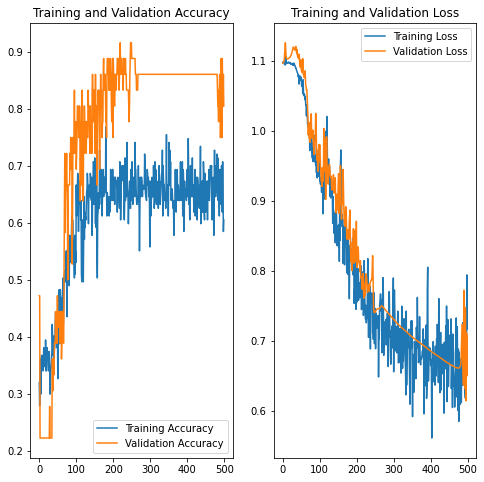

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save('model.h5')

In [35]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 56, 56, 64)      